### BRIa Project

Data is from: https://github.com/mastaneht/SPIS-Resting-State-Dataset

In [3]:
from scipy.io import loadmat
import mne

# SQL server user: xdedic07
# SQL server host: bria.mysql.database.azure.com

In [4]:
# load data/S02_restingPre_EC.mat
data_EC = loadmat('data/S02_restingPre_EC.mat')

# get only 64 EEG channels drop the rest
data_EC_filter = data_EC['dataRest'][:64]

# print the first 10 values of FP1
print(data_EC_filter[0])
eeg_EC = data_EC_filter * 1e-6 # convert to volts   
print(eeg_EC[0])

# create info object
info = mne.create_info(
    ch_names=['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3','P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz', 'Fp2','AF8','AF4','Afz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2','FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4','P6','P8','P10','PO8','PO4','O2'],#'EOG1','EOG2', 'EOGM','TRIG'],
    ch_types=['eeg']*64, #+ ['eog']*3 + ['misc']*1,
    sfreq=2048)

# create raw object
raw = mne.io.RawArray(eeg_EC, info)



[14128826.10645505 14129850.10834715 14125498.10030575 ...
 14407866.62205052 14408858.62388348 14404474.61578296]
[14.12882611 14.12985011 14.1254981  ... 14.40786662 14.40885862
 14.40447462]
Creating RawArray with float64 data, n_channels=64, n_times=38401
    Range : 0 ... 38400 =      0.000 ...    18.750 secs
Ready.


In [5]:
# print all keys in data_EC
print(data_EC.keys())

dict_keys(['__header__', '__version__', '__globals__', 'dataRest'])


In [8]:
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_channel_types({'Afz': 'misc'})
raw.set_montage(montage)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34044\1747477793.py:2: RuntimeWarning: The unit for channel(s) Afz has changed from V to NA.
  raw.set_channel_types({'Afz': 'misc'})


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,66 points
Good channels,"63 EEG, 1 misc"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6759 samples (3.300 s)



Fitting ICA to data using 63 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished


Selecting by non-zero PCA components: 63 components
 
Fitting ICA took 43.5s.


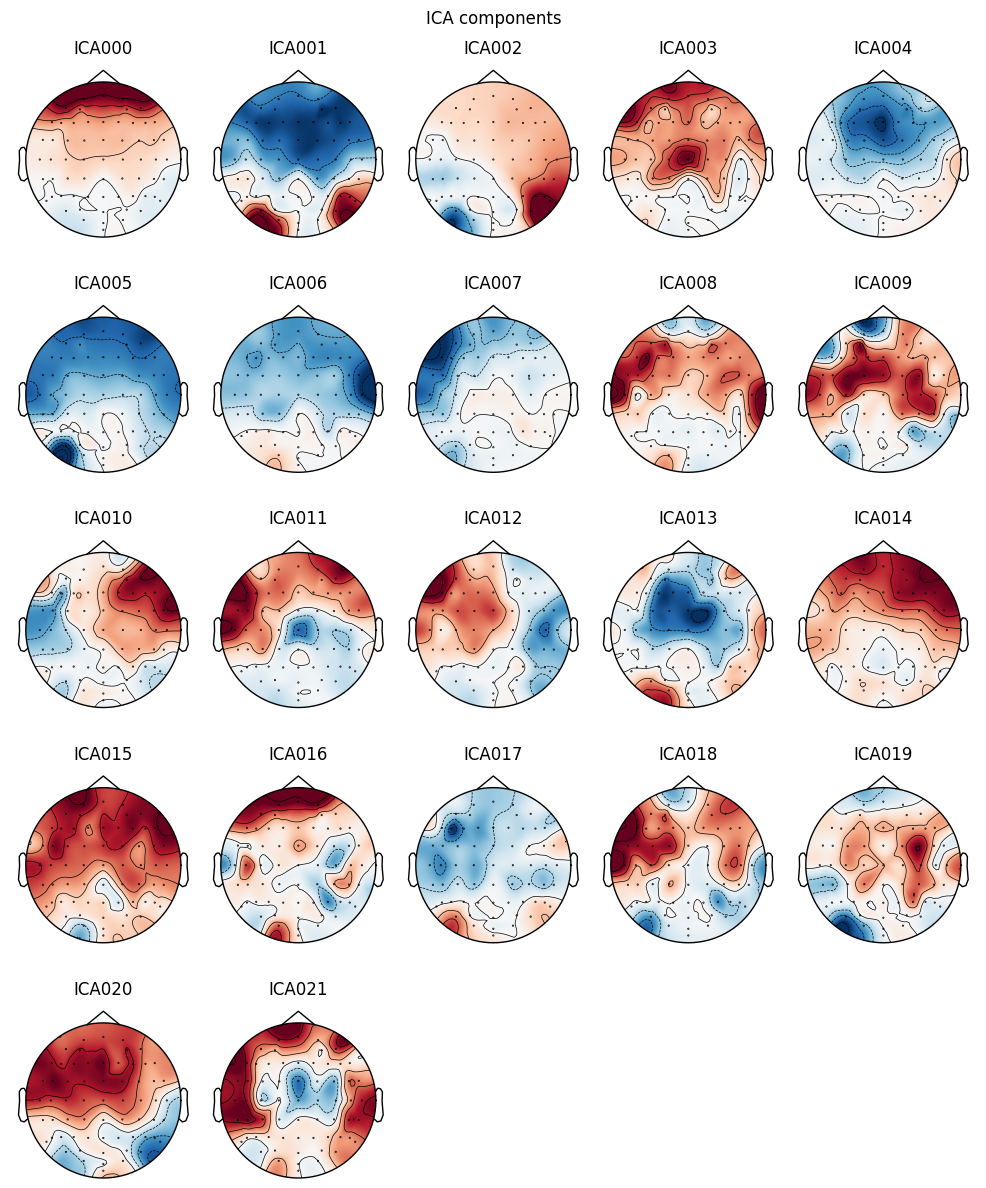

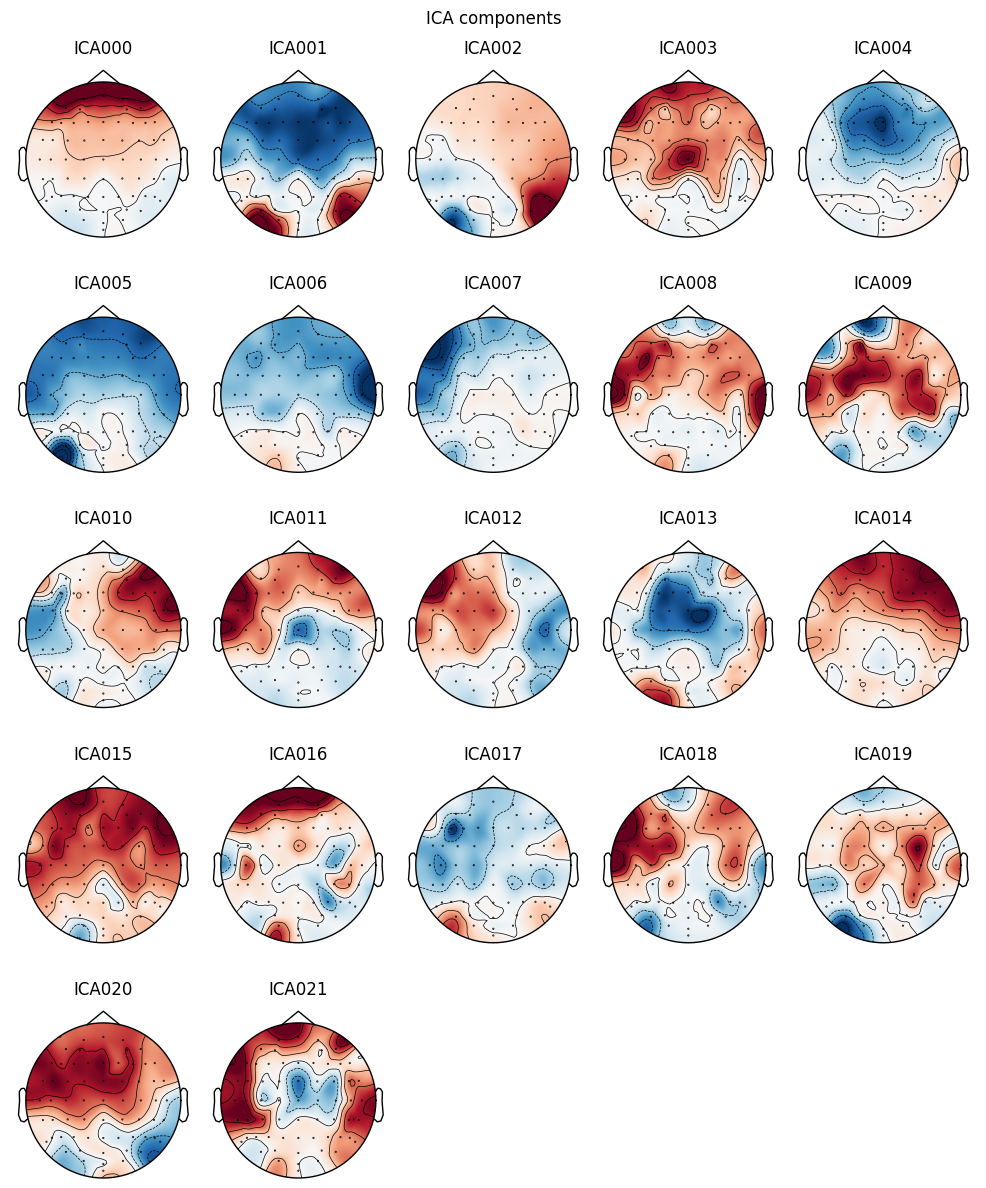

In [10]:
raw_tmp = raw.copy()
raw_tmp.filter(l_freq=1, h_freq=None)
ica = mne.preprocessing.ICA(method="infomax") 
fit_params={"extended": True}
random_state=1
ica.fit(raw_tmp)

ica.plot_components(inst=raw_tmp, picks=range(22))

Applying ICA to Raw instance
    Transforming to ICA space (63 components)
    Zeroing out 1 ICA component
    Projecting back using 63 PCA components


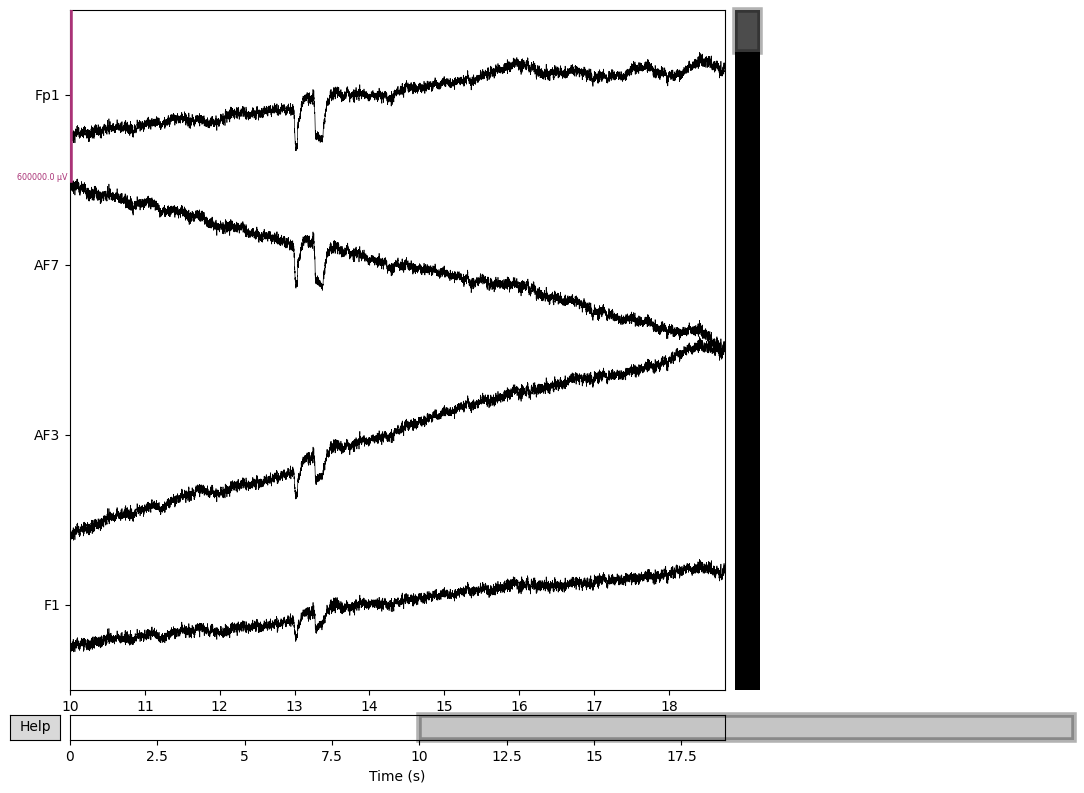

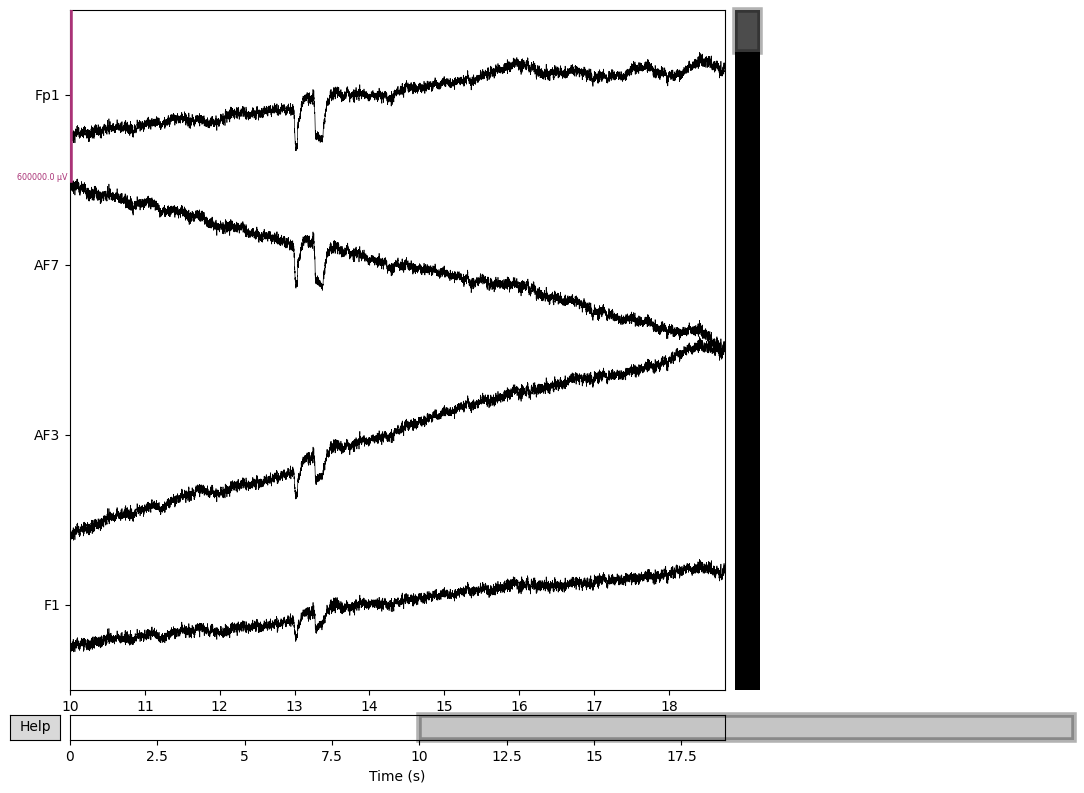

In [47]:
ica.exclude = [1]
raw_corrected = raw.copy()
ica.apply(raw_corrected)
raw_corrected.plot(n_channels=4, start=10, duration=30, title="Before", scalings=dict(eeg=0.3))

# DB Connection 

In [162]:
from db import Recording, DataChannel, Sample, engine

In [158]:
# create session
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)

session = Session(autoflush=False)

In [159]:
# add the experiment
from datetime import datetime

# add the recording
recording = Recording(name="Test recording EC", description="Eyes closed", sampling_rate=2048)
session.add(recording)

# add the data
import numpy as np
from tqdm import tqdm

for ch in info["chs"]:
    print(ch["ch_name"])
    

for i in tqdm(range(0, eeg_EC.shape[0])):
    channel_name = info['ch_names'][i]

    data_channel = DataChannel(channel_name=channel_name, recording=recording)
    session.add(data_channel)
    session.flush()


    data_dicts = []
    for val in eeg_EC[i]:
        data_dicts.append(dict(value=float(val), data_channel_id=data_channel.id))
    session.bulk_insert_mappings(Sample, data_dicts)

    # channel = Channel(name=channel_name, , number=i)
    for j in range(0, eeg_EC.shape[1]):
        # print(eeg_EC[i][j])
        # sample = Sample(value=float(eeg_EC[i][j]), data_channel=data_channel)
        # session.add(sample)
        pass

Fp1
AF7
AF3
F1
F3
F5
F7
FT7
FC5
FC3
FC1
C1
C3
C5
T7
TP7
CP5
CP3
CP1
P1
P3
P5
P7
P9
PO7
PO3
O1
Iz
Oz
POz
Pz
CPz
Fpz
Fp2
AF8
AF4
Afz
Fz
F2
F4
F6
F8
FT8
FC6
FC4
FC2
FCz
Cz
C2
C4
C6
T8
TP8
CP6
CP4
CP2
P2
P4
P6
P8
P10
PO8
PO4
O2


100%|██████████| 64/64 [01:49<00:00,  1.71s/it]


## Session remove edits

In [153]:
session.rollback()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34044\1760783211.py:1: SAWarning: Session's state has been changed on a non-active transaction - this state will be discarded.
  session.rollback()


## Session save edits

In [160]:
session.commit()